# First Test: Median filter with real data.

## DW (2015.11.23)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt, triang
import gitInformation

In [415]:
%matplotlib inline

In [3]:
gitInformation.printInformation()

Information about this notebook
Date: 2015-12-04
Python Version: 2.7.10 |Anaconda 2.4.0 (32-bit)| (default, Oct 28 2015, 14:01:20) [MSC v.1500 32 bit (Intel)]
Git directory: C:\Users\Dominik\Documents\GitRep\kt-2015-DSPHandsOn\.git
Current git SHA: d83b35fdcdbac98d4444c0599e18bb784d4fce29
Remotes: fork, origin, 
Current branch: master
fork remote URL: http://github.com/dowa4213/kt-2015-DSPHandsOn.git
origin remote URL: https://github.com/ktakagaki/kt-2015-DSPHandsOn.git


### Figure 1. Real Data

In [14]:
# Load some .ncs(neuralynx continuous sample file) data with nlxio
# nlxio taken from https://github.com/bwillers/nlxio
csc = nlxio.loadNcs('CSC2_2906536002_2913013352.ncs', should_read_time = False)

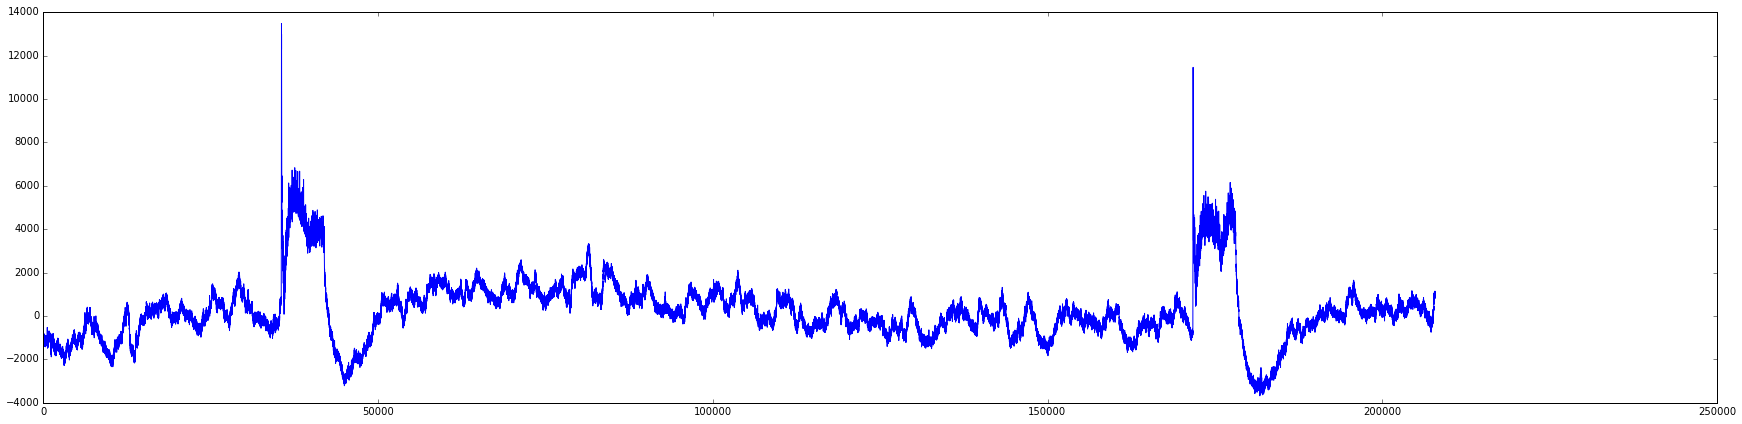

In [15]:
plt.figure(figsize=(30,7))
plt.plot(csc)

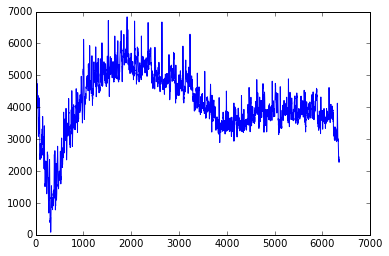

In [17]:
plt.plot(csc[35650:42000])

In [31]:
# Testing the median filter with some different window lengths.
wl = [71, 81, 91, 101, 111]

In [32]:
filtered = np.zeros((len(csc), len(wl)))

In [33]:
count = -1
for w in wl:
    count = count + 1
    # Median filter the csc data.
    filtered[:,count] = medfilt(csc, w)
np.savetxt("filtereddata.txt", filtered)

In [34]:
filtered = np.loadtxt('filtereddata.txt')

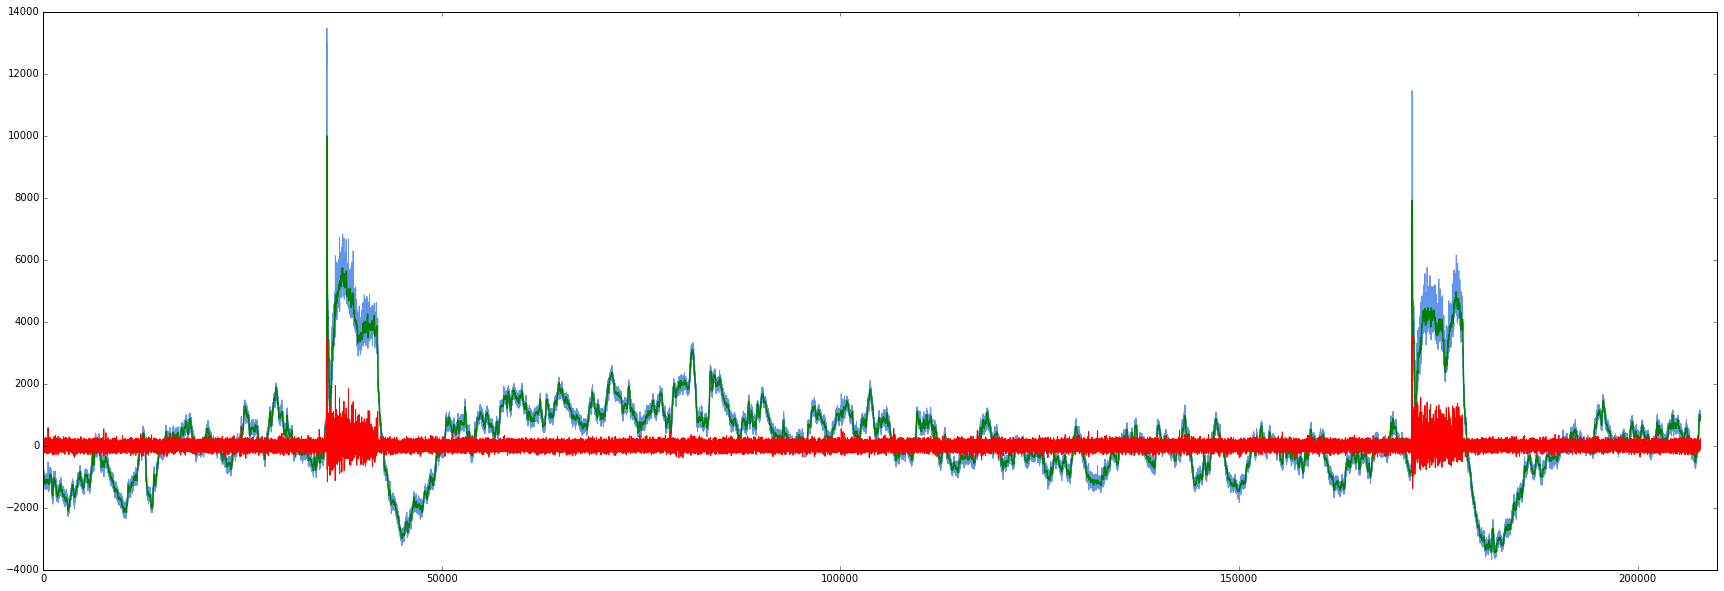

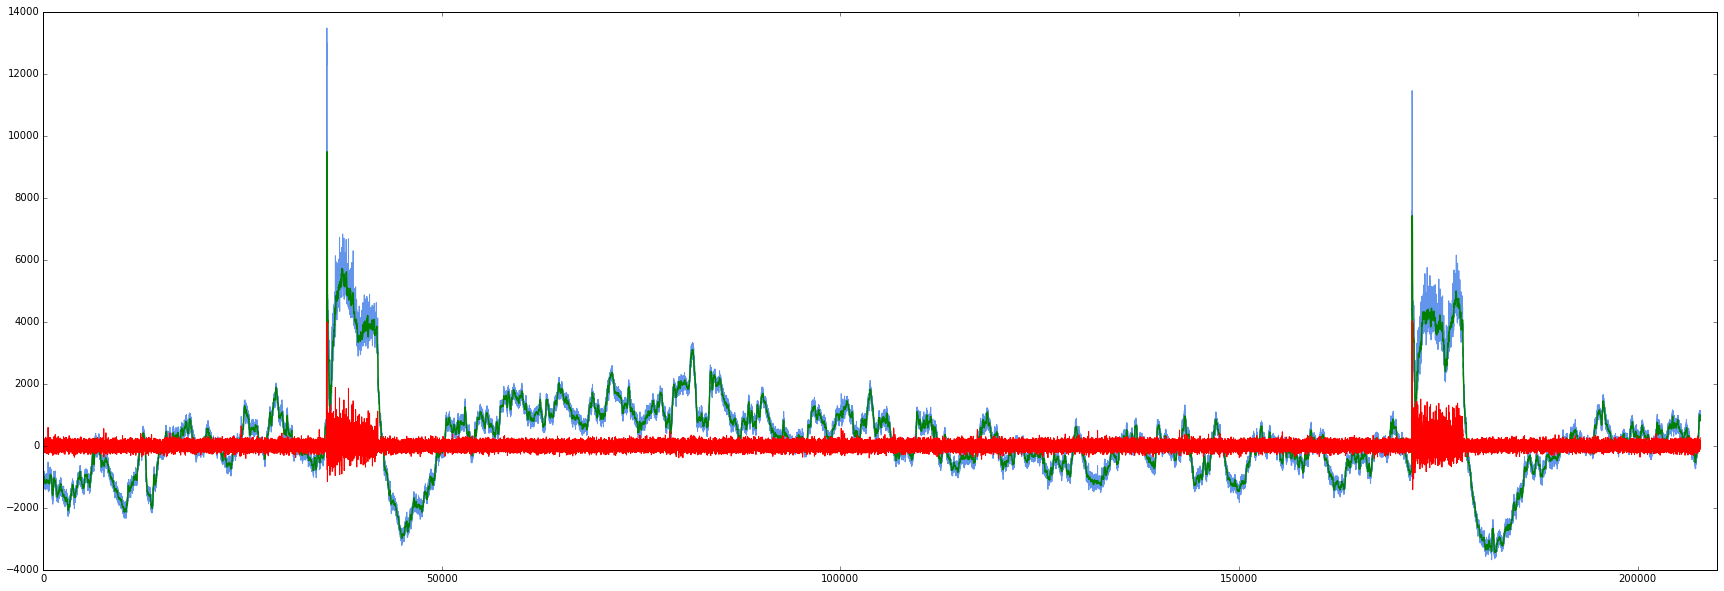

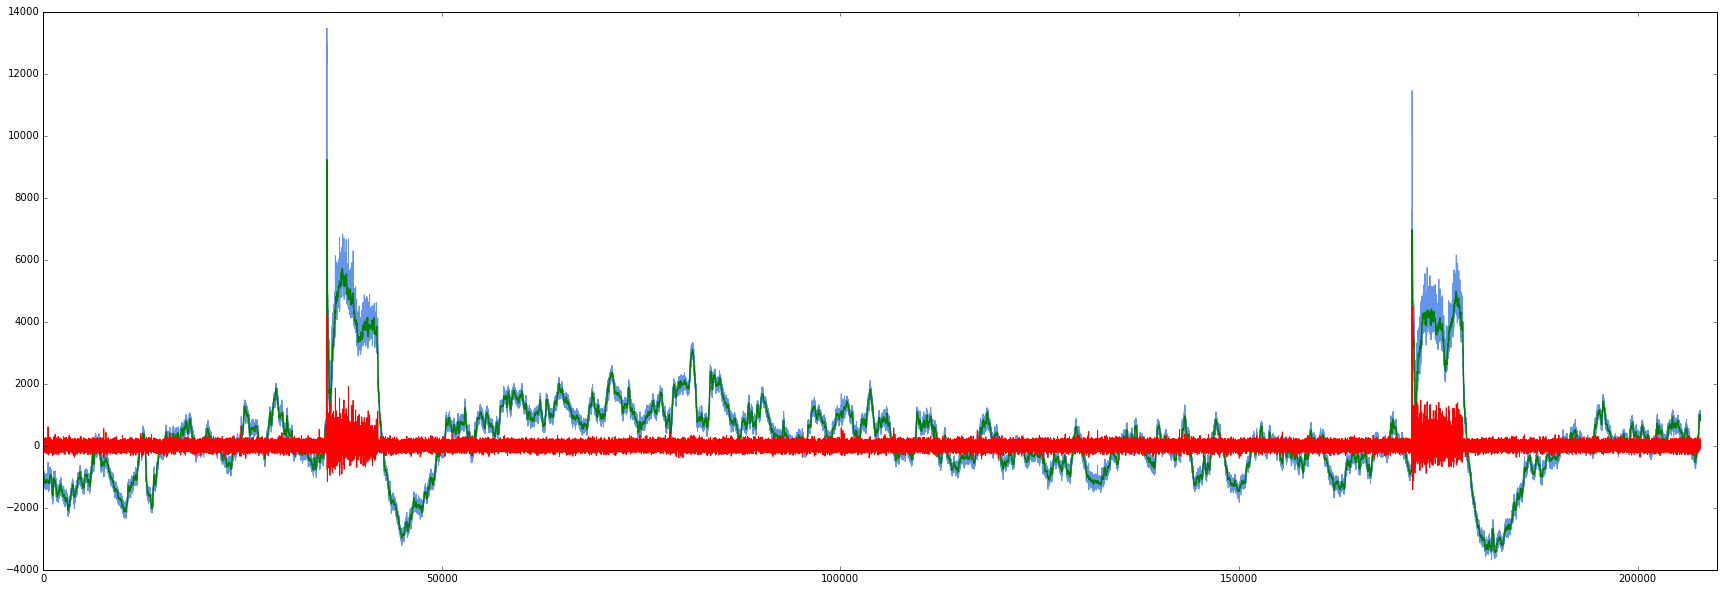

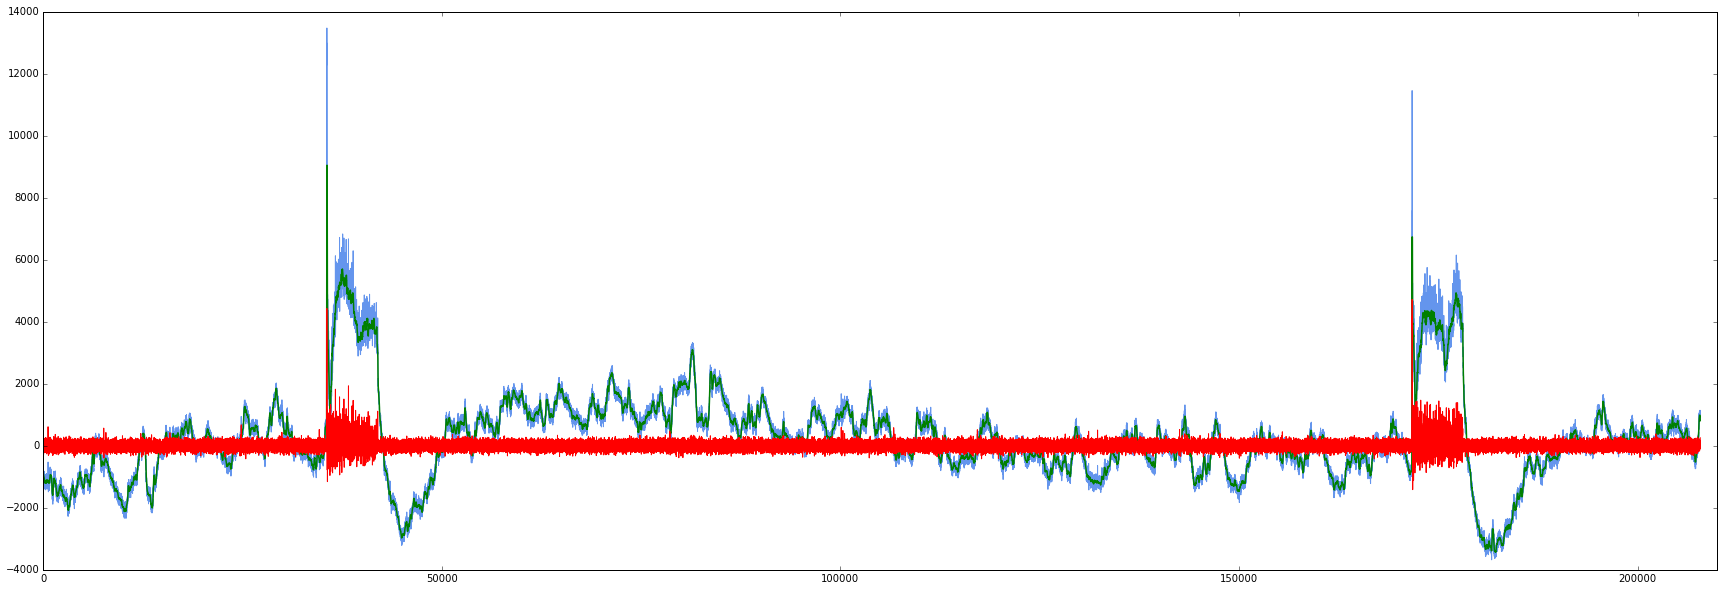

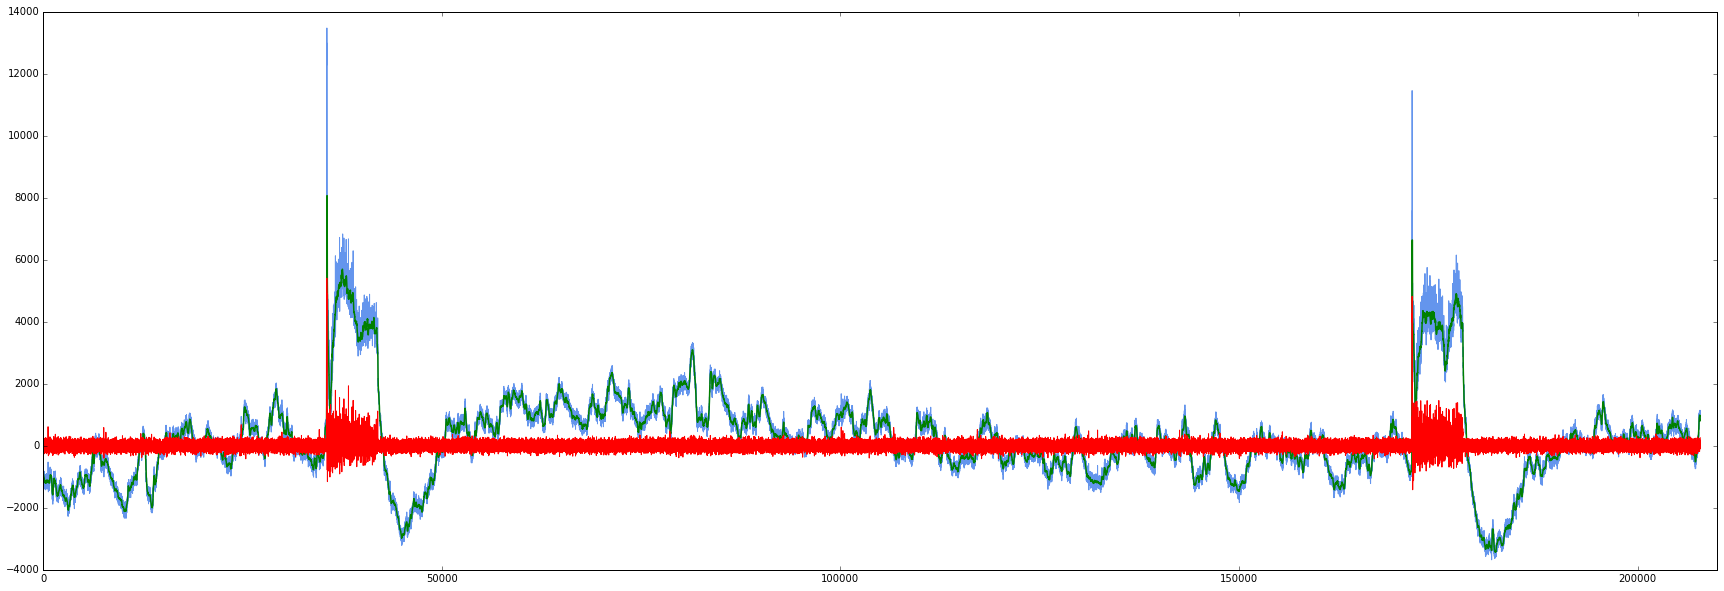

In [35]:
count = 0
for p in range(5):
    count = count + 1
    plt.figure(count, figsize=(30,10))
    plt.axis([0,210000, -4000,14000])
    plt.plot(csc, color = 'cornflowerblue')
    plt.plot(filtered[:,p], color = 'g', lw = 1.5)
    plt.plot(csc-filtered[:,p], color = 'r')

In [23]:
#filtered = medfilt(csc, 91)

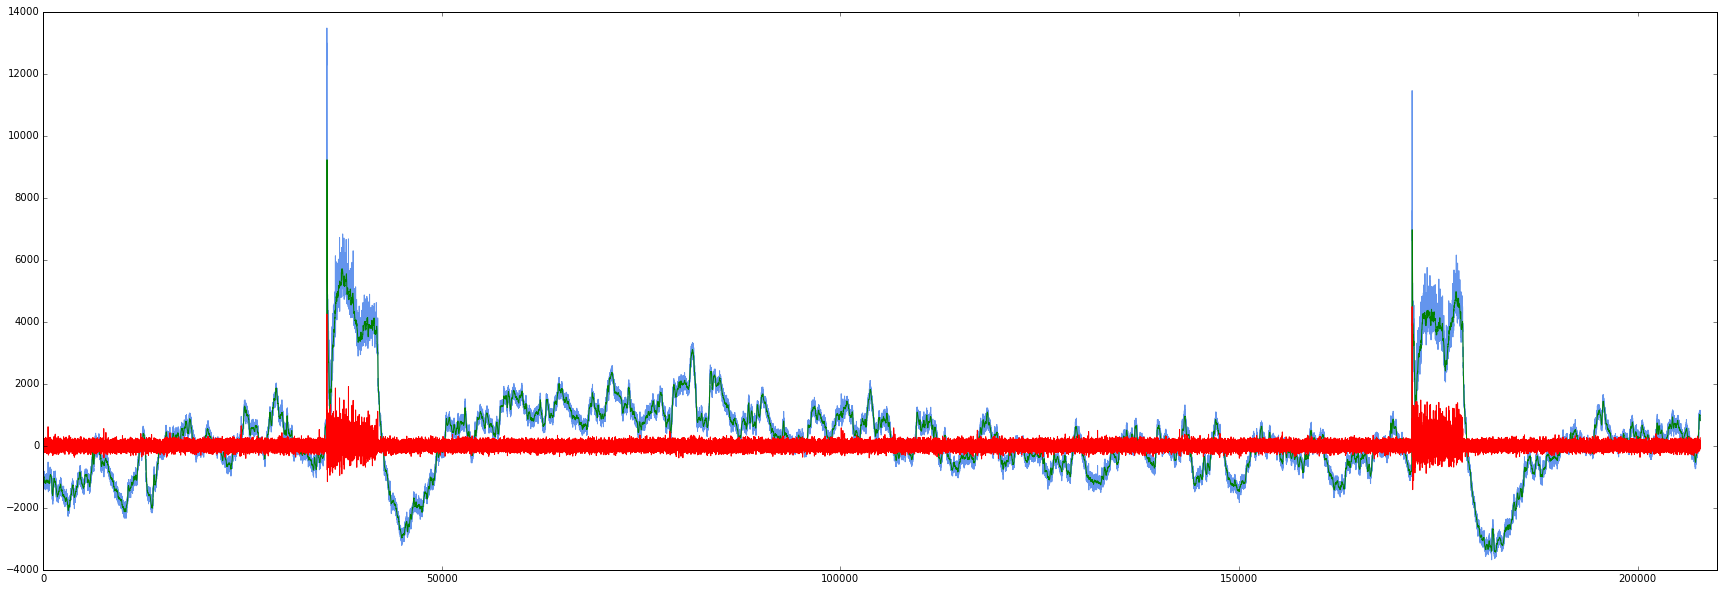

In [24]:
#plt.figure(figsize=(30,10))
#plt.axis([0,210000, -4000,14000])
#plt.plot(csc, color ='cornflowerblue')
#plt.plot(filtered, color = 'g')
#plt.plot(csc-filtered, color = 'r')

In [25]:
#filtered= csc - filtered

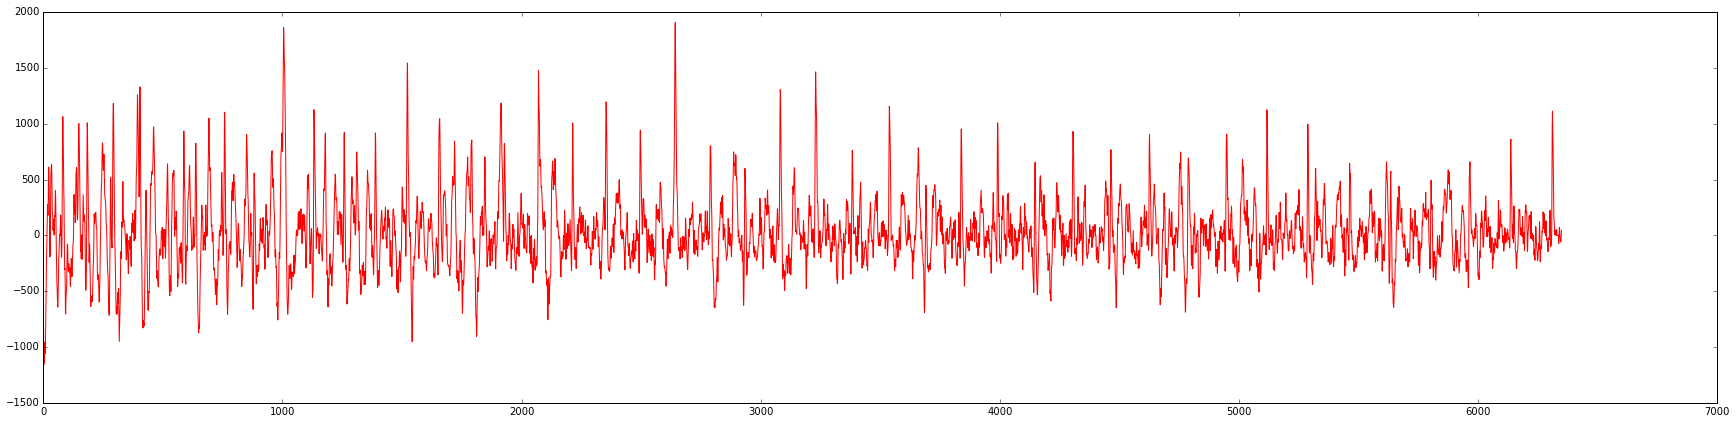

In [26]:
#plt.figure(figsize=(30,7))
#plt.plot(filtered[35650:42000], color = 'r')

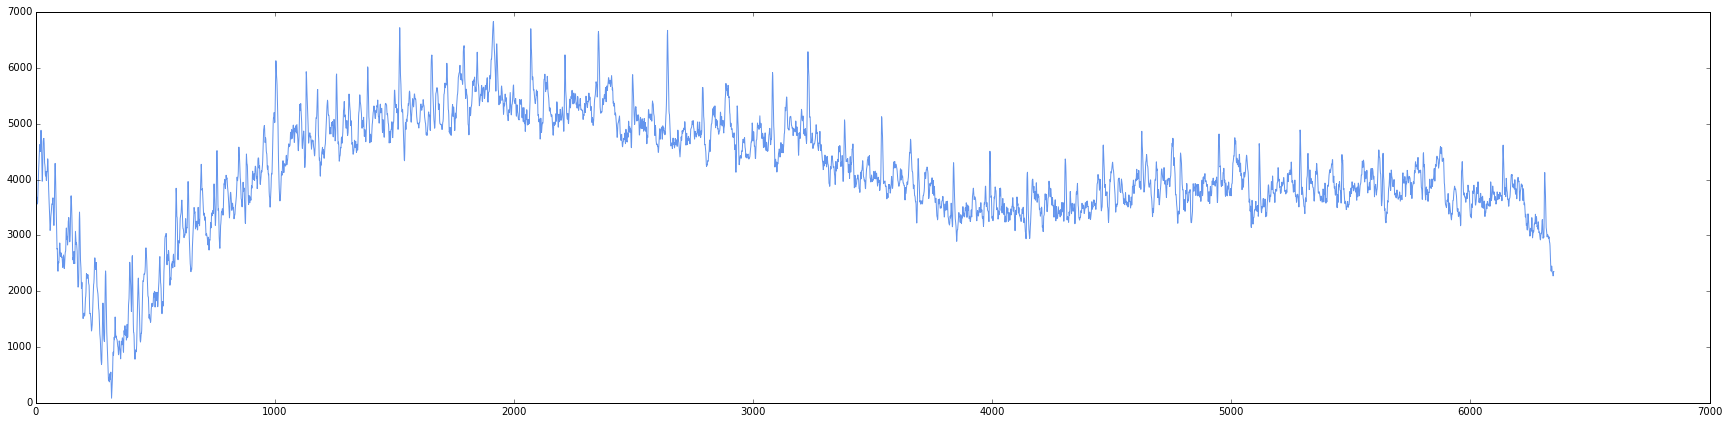

In [27]:
#plt.figure(figsize=(30,7))
#plt.plot(csc[35650:42000], color = 'cornflowerblue')

## Thresholding

In [36]:
new_data = np.zeros(len(csc))
new_data = csc-filtered[:,3]

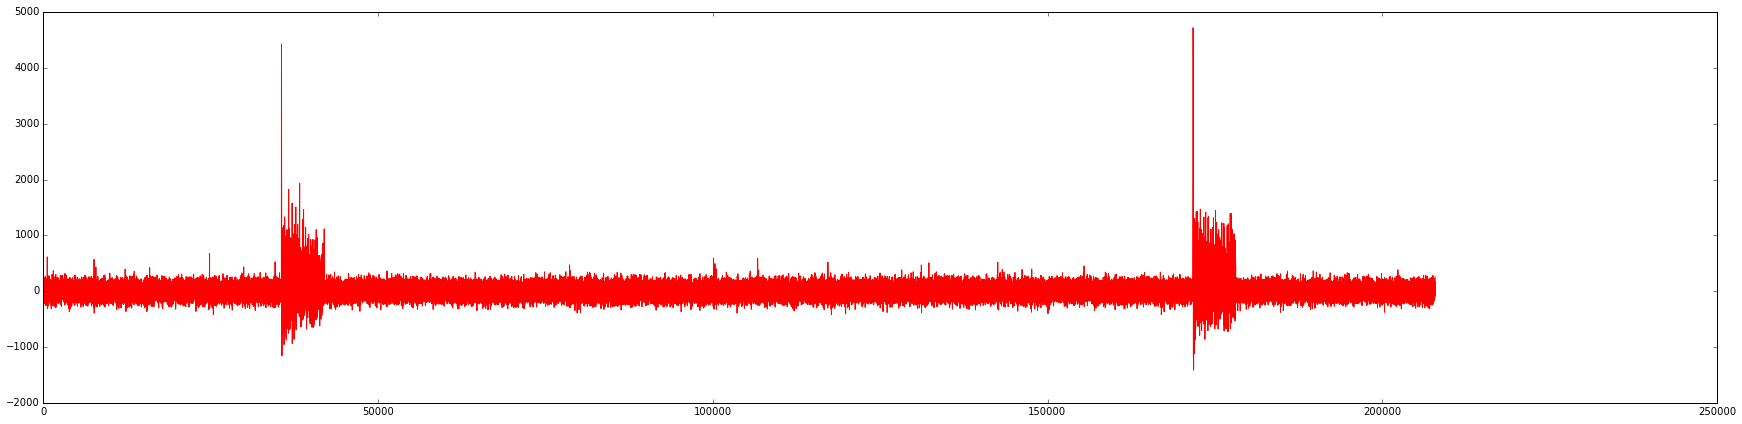

In [37]:
plt.figure(figsize=(30,7))
plt.plot(new_data, color = 'r')

In [426]:
# Declaring counter and and dead time.
# Dead time: if the threshold is reached, we wait 50 samples until the threshhold will be
# activated again
count  = -1
count2 = 0
timer = 0
# Dictionary with all thresholded shapes
thresholds = {}
# Get the value in the new_data array:
for i in new_data:
    # Increment the counter (counter = position in the array)
    count += 1
    # if the value is bigger then 800, the threshold is reached
    if i >= 800:
        # check the thresholded window if some values are bigger then 2500.
        temp = [i for i in new_data[count -20 : count + 30] if i >= 1500 or i <= - 750]
        # If no values are bigger then 2500 and the dead time is zero,
        # save the window in the dictionary 
        if len(temp) == 0 and timer == 0:
            # set the timer to 50, so 50 samples will be passed
            timer = 50
            # increment count2, for the array name
            count2 += 1
            thresholds["spike{0}".format(count2)] = new_data[count -20 : count + 30]
    elif timer > 0: 
        # Decrement the timer.
        timer -= 1
    else: 
        pass

In [429]:
# Transfrom the thresholded shpaes into a array
thresholds_array = np.zeros((50,len(thresholds)))
count = -1
for o in thresholds:
    count += 1
    thresholds_array[:,count] = thresholds[o]

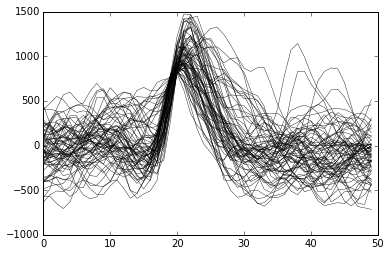

In [430]:
for o in range(len(thresholds_array[1,:])):
    plt.plot( thresholds_array[:,o], color = 'black', linewidth = 0.4)

## Normalize data

In [431]:
thresholds_norm = thresholds_array/float(thresholds_array.max())

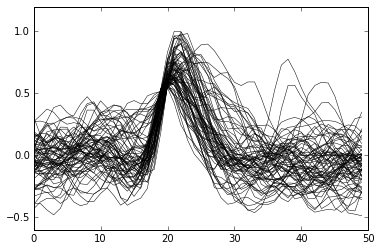

In [432]:
for o in range (len(thresholds_norm[1,:])):
    plt.plot(thresholds_norm[:,o], color = 'black', linewidth = 0.5)

## RBF (Radial basis function) interpolation

In [433]:
from scipy.interpolate import Rbf

In [434]:
x = np.arange(50)
x_new = np.linspace(0,50, 500)
thresholds_interp = np.zeros((len(x_new),len(thresholds_norm[1,:])))
count = 0
for o in range(len(thresholds_norm[1,:])):
    count += 1
    newfunc = Rbf(x, thresholds_norm[:,o])
    thresholds_interp[:,o] = newfunc(x_new)

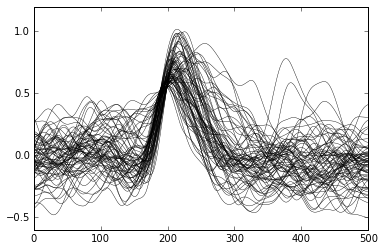

In [435]:
for o in range(len(thresholds_interp[0,:])):
    plt.plot( thresholds_interp[:,o], color = 'black', linewidth = 0.4)

## PCA ( Principal Component Analysis)

In [436]:
from sklearn.decomposition import PCA, FastICA

In [443]:
X_reduced = (PCA(n_components=1).fit_transform(thresholds_interp))
X_reduced2 = PCA(n_components=3).fit_transform(thresholds_norm)

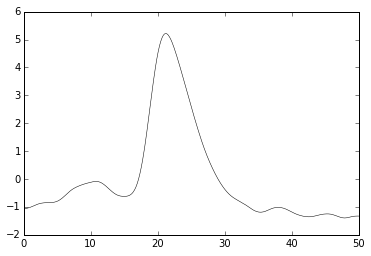

In [444]:
x = np.linspace(0,50,500)
plt.plot(x, X_reduced, color = 'black', linewidth = 0.5)
#plt.plot(X_reduced2, color = 'black', linewidth = 0.5)

## ICA ( Independent Component Analysis)

In [445]:
ica = FastICA(n_components=1)
bla = ica.fit_transform(thresholds_interp)

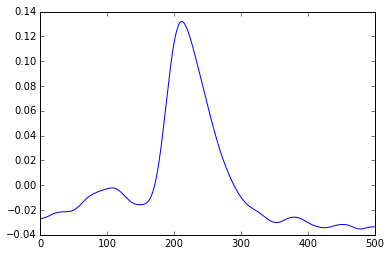

In [447]:
plt.plot(bla)